In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

In [2]:
# create a 5x5 (treatment x replicate) matrix (vel) where we store the velocities for each trial
# each data point in the matrix contains an array of shape [t, N, 2] where t = time, N = number of fish, 2 (x and y coordinates for velocity)

replicates = ['6', '7', '8', '9', '10']
treatments = [
    'RB16',
    'RB12+TB4',
    'RB8+TB8',
    'RB4+TB12',
    'TB16'
]

vel = np.empty((5, 5), dtype=object)
pos = np.empty((5, 5), dtype=object)

for t, treatment in enumerate(treatments):
    for r, replicate in enumerate(replicates):
        filename = f'/Users/jahanvitiwari/Desktop/Arshad modified codes/cleaned data GS16/MS_RB+TB_{replicate}_{treatment}_traj.npz'
        try:
            data = np.load(filename)
            vel[t][r] = data['velocities']
            pos[t][r] = data['positions']
        except:
            print(f'File: {filename} not found.')

In [3]:
# store the mean body length for each trial under bl

bl = np.array([
    [3.244,	3.347,	3.484,	4.380,	4.386],
    [3.501,	3.616,	4.201,	3.952,	4.187],
    [3.468,	3.583,	3.883,	4.042,	4.135],
    [3.574,	3.650,	3.467,	3.796,	3.951],
    [3.819,	3.660,	3.714,	3.592,	3.672]
])

# bl[4][2] = 3.952 is the average of other trials in the replicate, because missing data.

In [4]:
# divide the velocity vector by mean body length to calibrate the data from cm to body length

for t in range(5):
    for r in range(5):
        vel[t][r] /= bl[t][r]
        pos[t][r] /= bl[t][r]


In [5]:
replicates = ['1', '2', '3', '4', '5']

In [6]:
# GROUP SPEED ANALYSIS

In [7]:
# create speed matrix with similar shape as vel where all the speed values is stored
# using linalg.norm, calculate the speed values for each time point for each trial

speed = np.empty_like(vel)
for t in range(5):
    for r in range(5):
        speed[t][r] = np.linalg.norm(vel[t][r], axis=2)

In [8]:
speed[1][2].shape

(92388, 16)

In [9]:
# exclude the zero values

for t in range(5):
    for r in range(5):
        speed[t][r][speed[t][r] < 0.01] = np.nan

In [10]:
# calculate the pairwise speed difference for each trial at each time point to visualize speed synchronisation
# create an empty matrix (pw_speed_diff) similar to speed to store the speed difference values
# each point in the matrix will have an array of shape T, N, N

pw_speed_diff = np.empty_like(speed)
for treatment in range(5):
    for replicate in range(5):
        T, N = speed[treatment, replicate].shape
        pw_speed_diff[treatment, replicate] = np.empty((T, N, N))
        for time in range(T):
            speed_diff = (np.subtract.outer(speed[treatment, replicate][time], speed[treatment, replicate][time]))
            np.fill_diagonal(speed_diff, np.nan)
            pw_speed_diff[treatment, replicate][time, :, :] = speed_diff

In [11]:
# look at the shape of the data

pw_speed_diff[1][2].shape

(92388, 16, 16)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

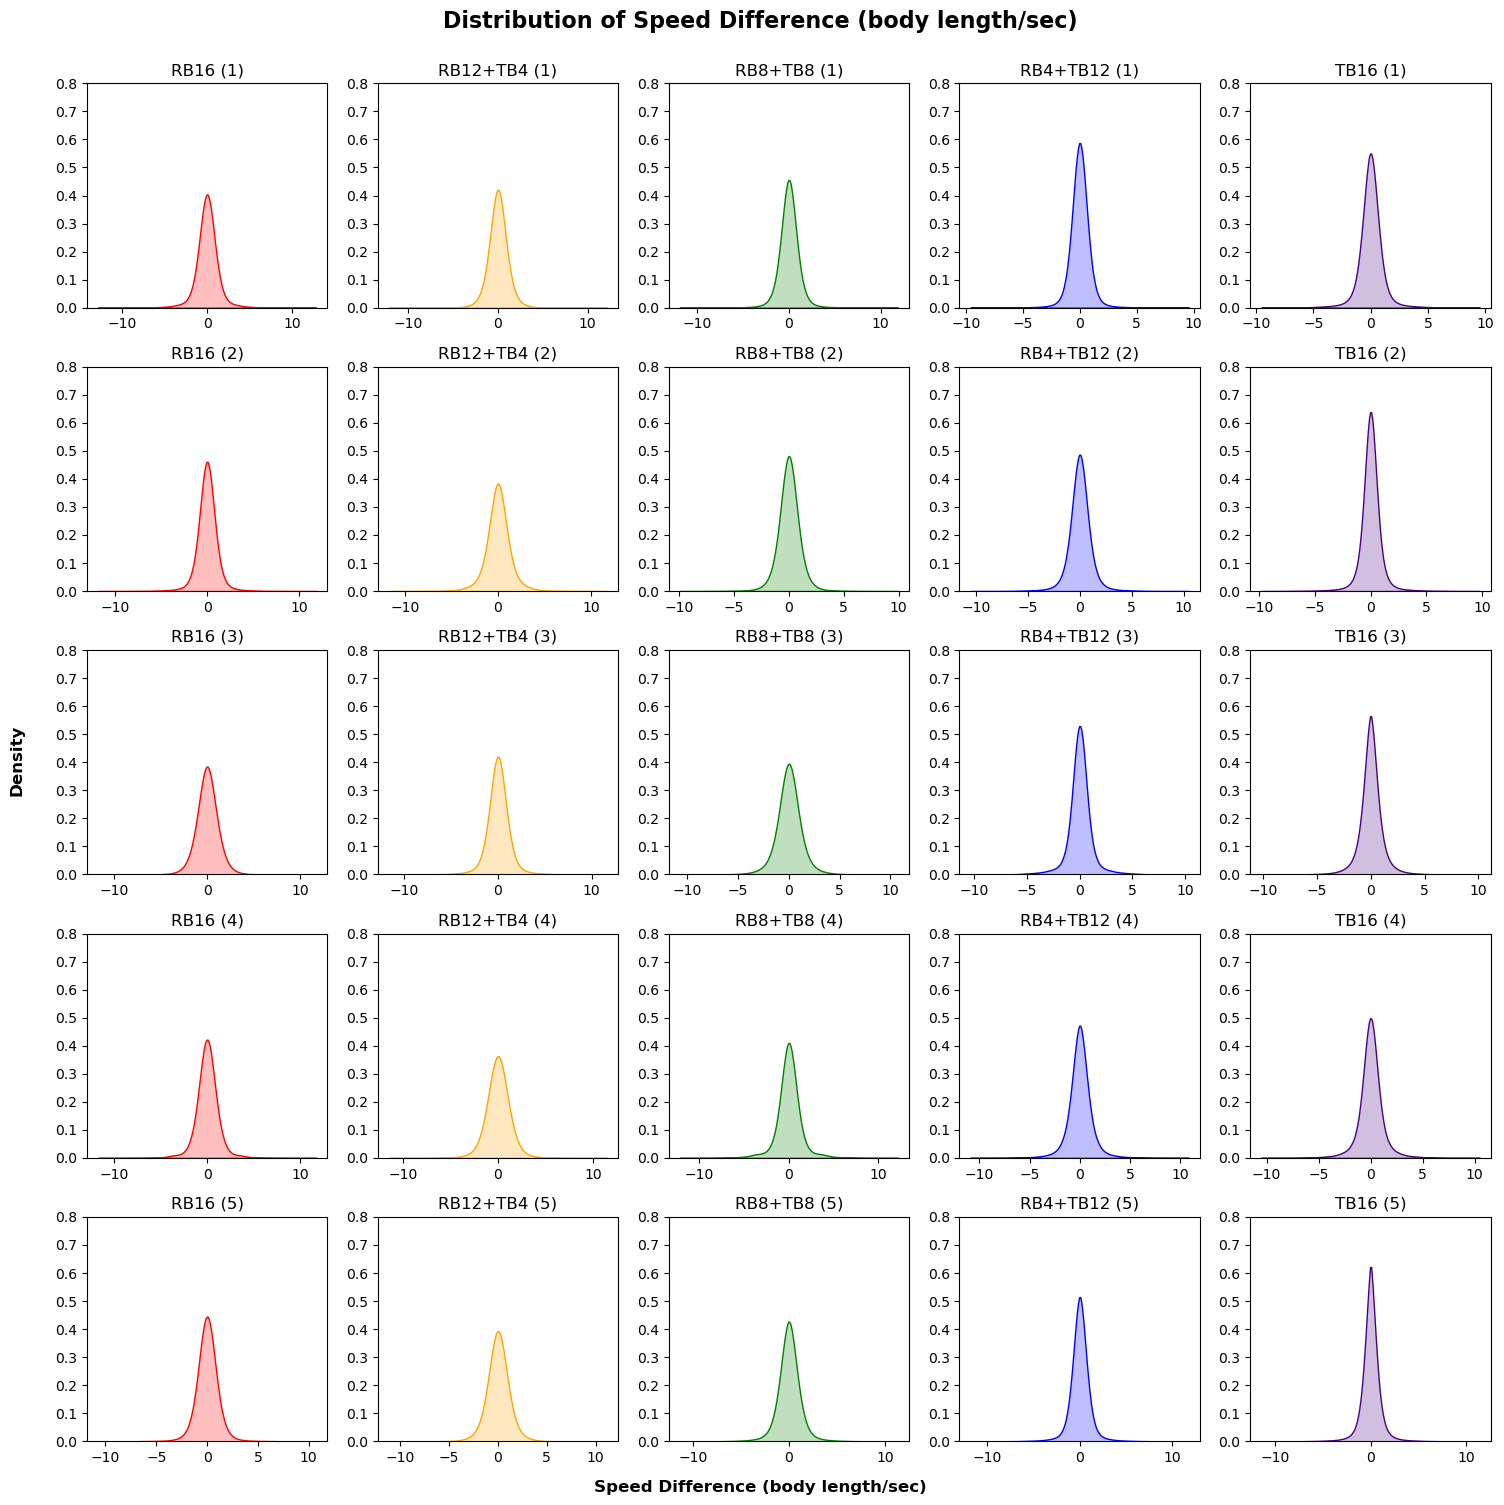

In [28]:
# Plot the pairwise speed difference, replicate-wise

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5):
    for j in range(5):
        index = i * 5 + j  # Calculate the index of ind_speed
        sns.kdeplot(pw_speed_diff [i][j].ravel(),
                    ax=axes[i, j], fill=True, color=colors[index % len(colors)])
        
        axes[i, j].set_ylim(0, 0.8)
        #axes[i, j].set_xlim(0, 12)
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')


fig.suptitle('Distribution of Speed Difference (body length/sec)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Speed Difference (body length/sec)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('distribution_of_speed_difference_replicatewise_kde_bodylength.png', bbox_inches='tight')


In [10]:
# Plot the speed difference 

sns.set(style='whitegrid')
sns.set_palette('muted')

fig = plt.figure(figsize=(8, 6))

colors = ['red', 'orange', 'yellow', 'green', 'blue']
labels = ['RB 16', 'RB 12 + TB 4', 'RB 8 + TB 8', 'RB 4 + TB 12', 'TB 16']
for i in range(5): # treatment
    sd = np.empty((0, 16, 16))
    for j in range(5): #replicate
        sd = np.concatenate((sd, pw_speed_diff[i][j]))

    sns.kdeplot(sd.ravel(), fill=False, color=colors[i], label=labels[i])

plt.title("Speed difference")
plt.xlabel("Speed Difference(body length/sec)")
plt.ylabel("Density")
plt.legend()
fig.show()
fig.savefig('individual_speed_difference_plot.png', dpi=300, bbox_inches='tight')

NameError: name 'pw_speed_diff' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# INDIVIDUAL SPEED PLOT (CONCATENATE)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5): # treatment
    s = np.empty((0, 16))
    for j in range(5): #replicate
        s = np.concatenate((s, speed[i][j]))
        
    sns.kdeplot(s.ravel(), ax=axes[i], fill=True, color=colors[i])
    
    axes[i].set_ylim(0, 0.5)
    axes[i].set_xlim(0, 10)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(f'{treatments[i]}')

fig.suptitle('Distribution of Individual Speed (body length/sec)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Individual Speed (body length/sec)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('distribution_of_individual_speed_concatenate_bodylength.png', bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

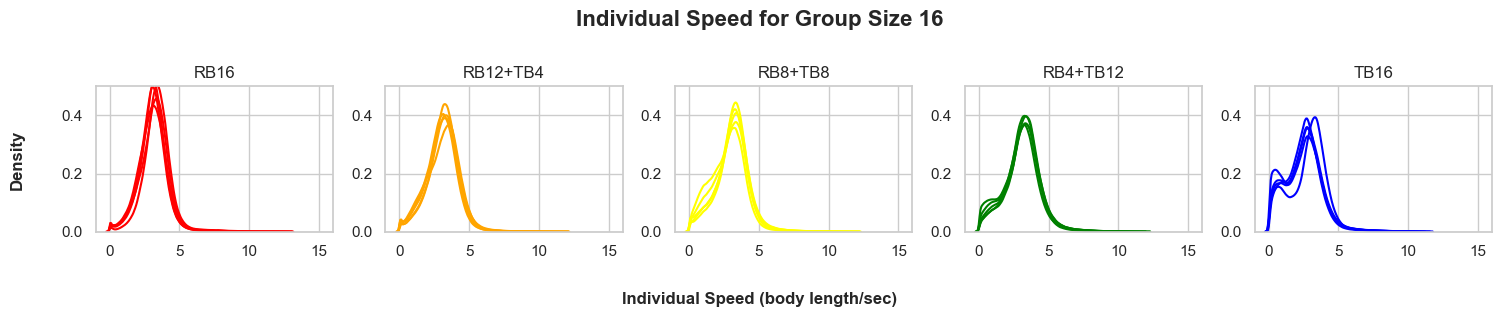

In [16]:
#INDIVIDUAL SPEED PLOT (CONCATENATE)
sns.set(style='whitegrid')
sns.set_palette('muted')

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

colors = ['red', 'orange', 'yellow', 'green', 'blue']

for i in range(5): # treatment
    s = np.empty((0, 16))
    for j in range(5): #replicate
        s = np.concatenate((s, speed[i][j]))
        
        sns.kdeplot(s.ravel(), ax=axes[i], fill=False, color=colors[i])
        
        
        axes[i].set_ylim(0, 0.5)
        axes[i].set_xlim(-1, 16)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        axes[i].set_title(f'{treatments[i]}')

fig.suptitle('Individual Speed for Group Size 16', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Individual Speed (body length/sec)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('individual_speed_concatenate_GS16_bl.png', bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

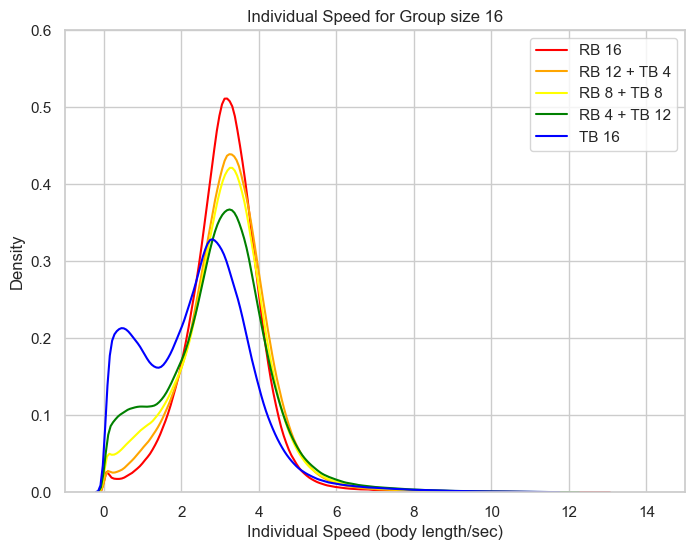

In [13]:
# INDIVIDUAL SPEED PLOT

sns.set(style='whitegrid')
sns.set_palette('muted')

fig = plt.figure(figsize=(8, 6))

colors = ['red', 'orange', 'yellow', 'green', 'blue']
labels = ['RB 16', 'RB 12 + TB 4', 'RB 8 + TB 8', 'RB 4 + TB 12', 'TB 16']
for i in range(5): # treatment
    s = np.empty((0, 16))
    for j in range(5): #replicate
        s = np.concatenate((s, speed[i][j]))

        
    sns.kdeplot(s.ravel(), fill=False, color=colors[i], label=labels[i])
    plt.xlim(-1,15)
    plt.ylim(0,0.6)


# Add titles and labels
plt.title("Individual Speed for Group size 16")
plt.xlabel("Individual Speed (body length/sec)")
plt.ylabel("Density")
plt.legend()
fig.show()
fig.savefig('individual_speed_plot.png', dpi=300, bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

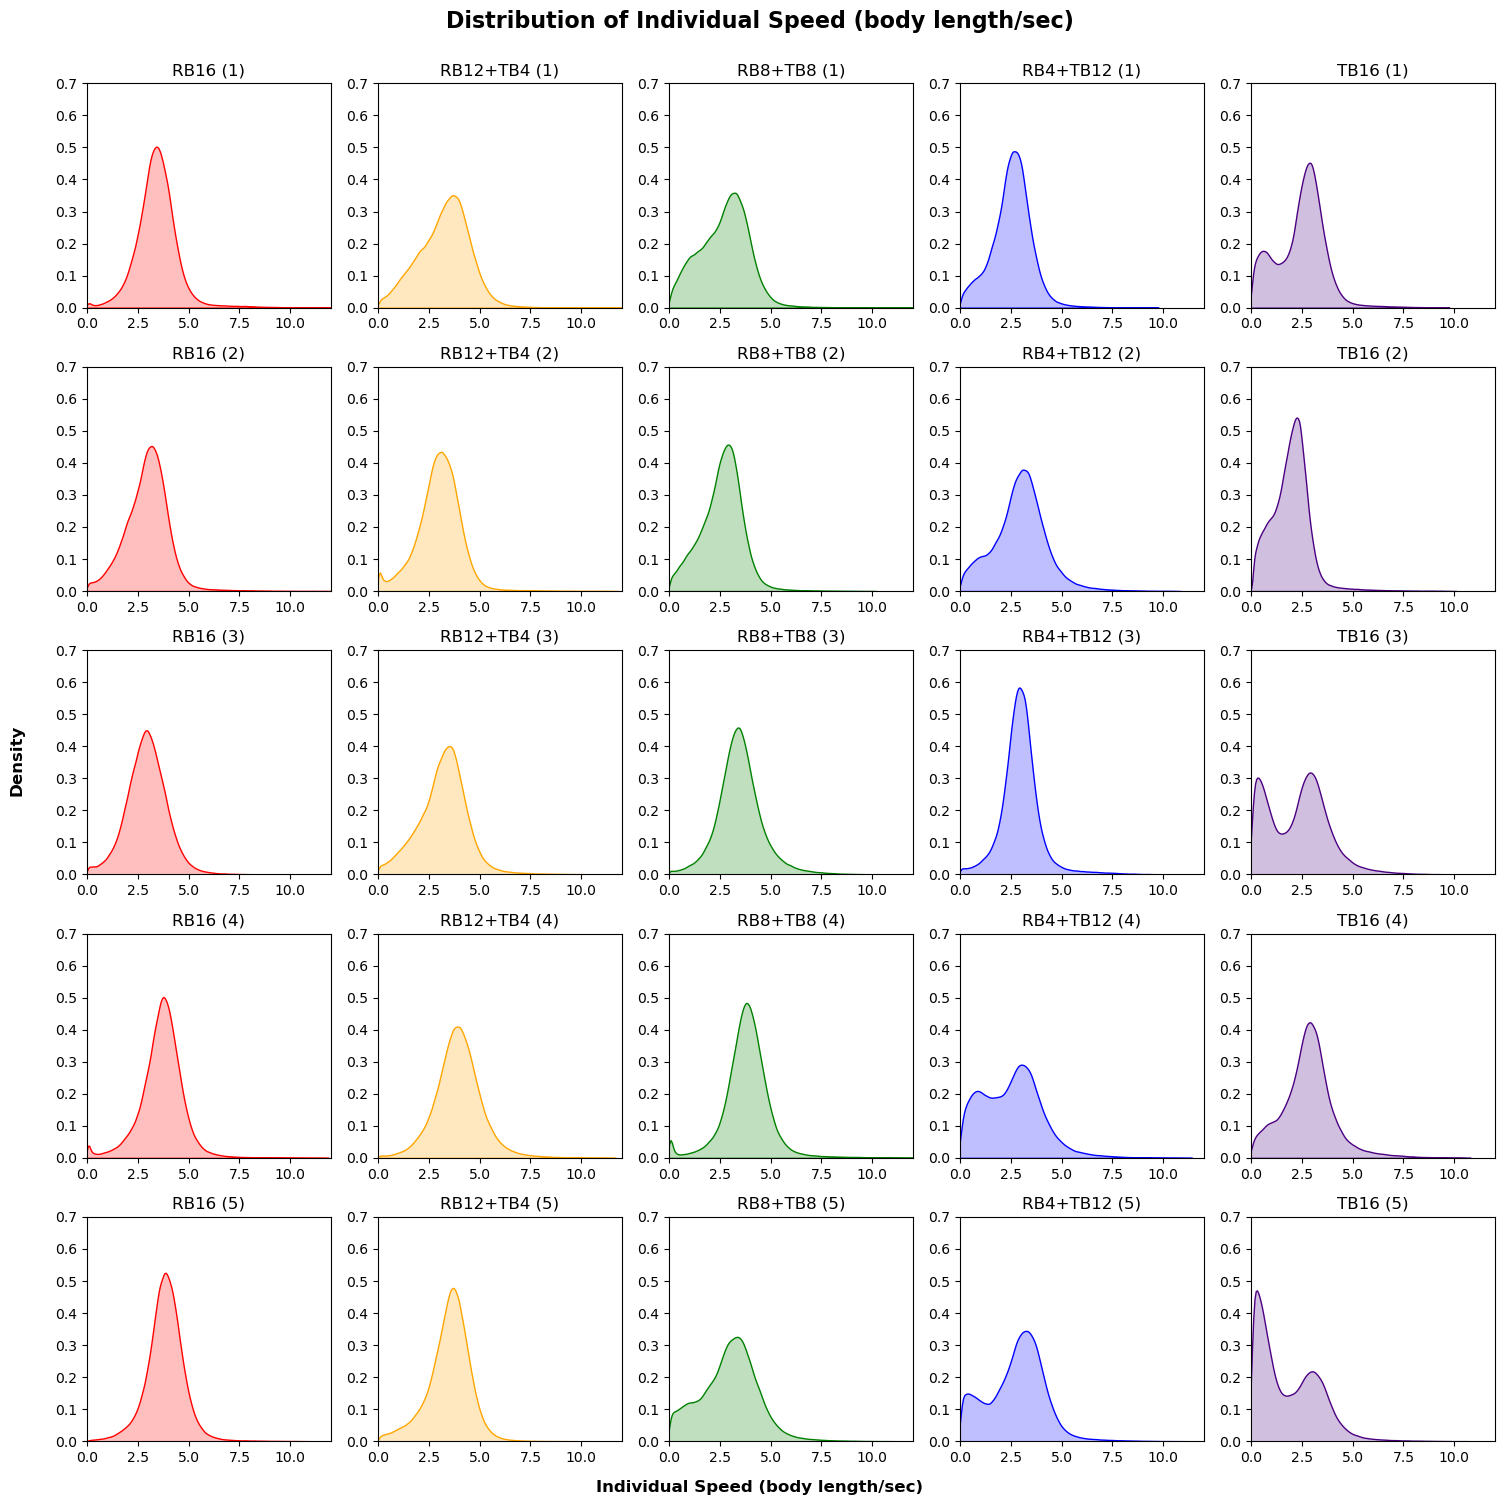

In [13]:
# INDIVIDUAL SPEED PLOT REPLICATES WISE

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5):
    for j in range(5):
        index = i * 5 + j  # Calculate the index of ind_speed
        sns.kdeplot(speed[i][j].ravel(),
                    ax=axes[i, j], fill=True, color=colors[index % len(colors)])
        
        axes[i, j].set_ylim(0, 0.7)
        axes[i, j].set_xlim(0, 12)
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')


fig.suptitle('Distribution of Individual Speed (body length/sec)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Individual Speed (body length/sec)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('distribution_of_individual_speeds_replicatewise_bodylength.png', bbox_inches='tight')


/var/folders/yx/fr740nw51gx5ylj1n1z8jp7c0000gn/T/ipykernel_2501/49327372.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


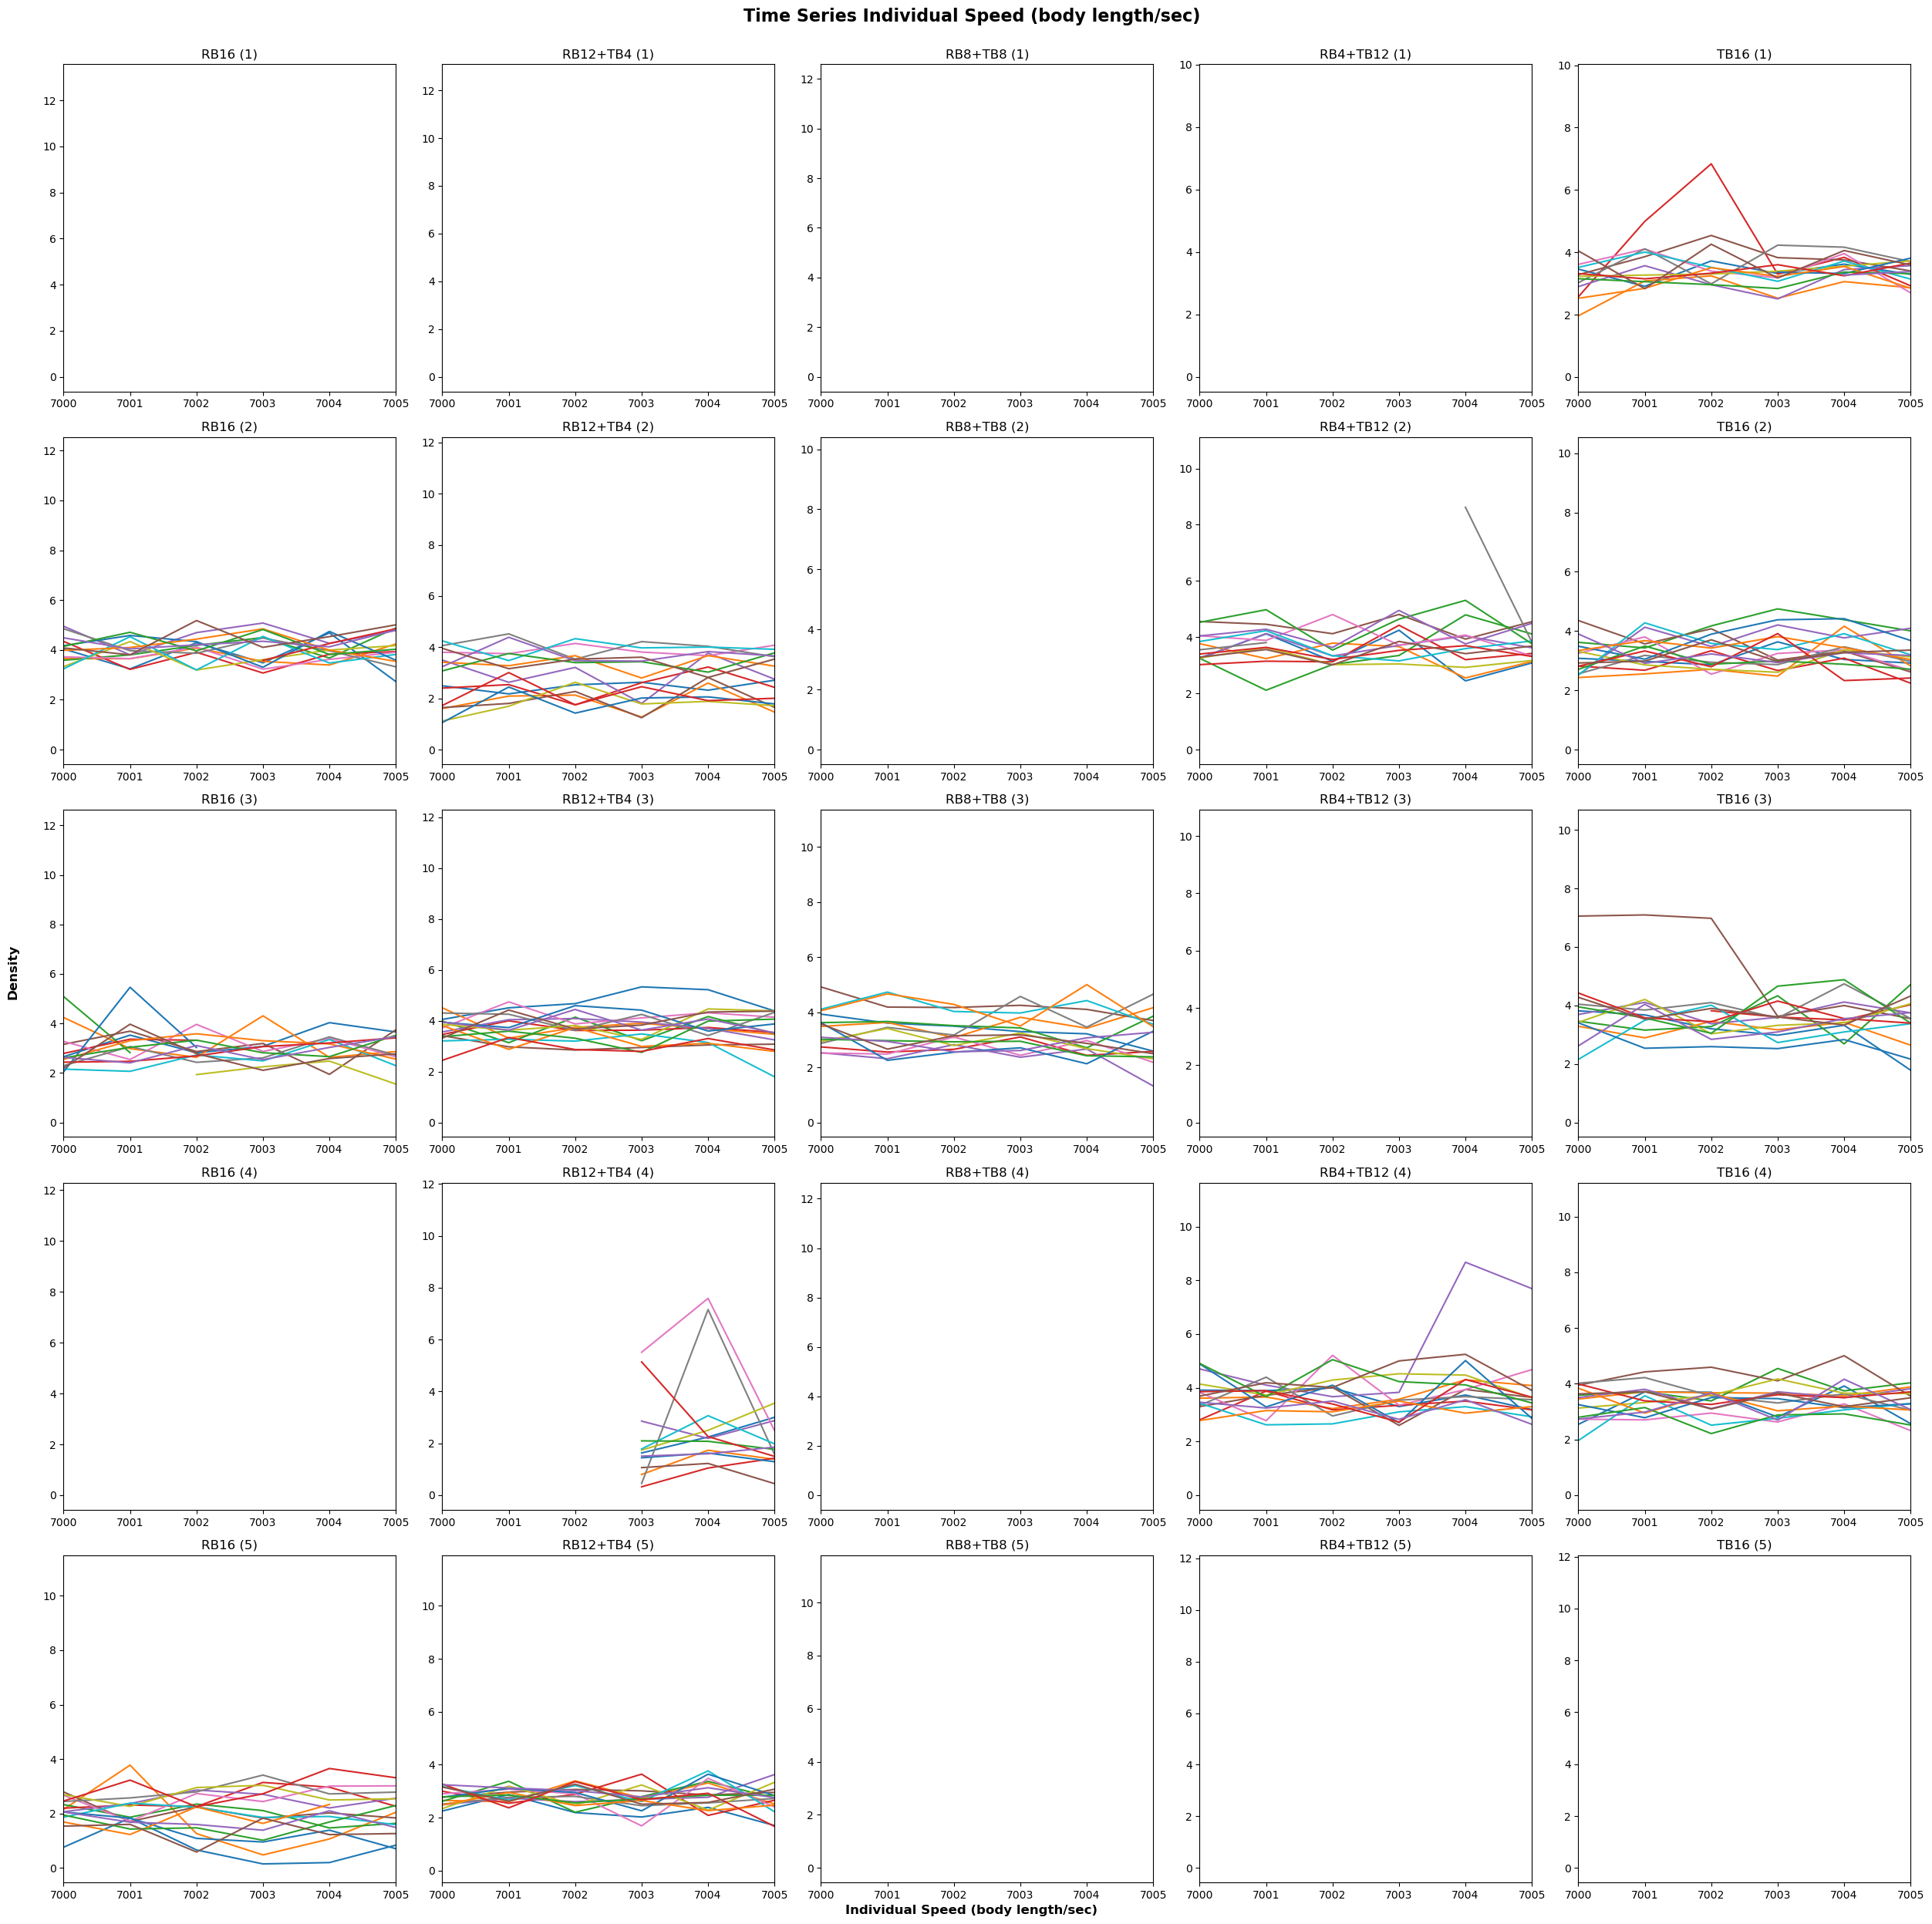

In [20]:
# INDIVIDUAL SPEED PLOT REPLICATES WISE

fig, axes = plt.subplots(5, 5, figsize=(25, 25))

for i in range(5):
    for j in range(5):
        index = i * 5 + j  # Calculate the index of ind_speed
        axes[i,j].plot(speed[i][j])
        
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlim(7000,7005)
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')


fig.suptitle('Time Series Individual Speed (body length/sec)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Individual Speed (body length/sec)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('time series_individual_speeds_replicatewise_bodylength_gs16.png', bbox_inches='tight')


In [ ]:
#INTER INDIVIDUAL DISTANCE

In [33]:
pw_dist = np.empty((5,5), dtype = object)
for treatment in range (5):
    for replicate in range (5):
        T, N = pos[treatment, replicate].shape[:2]
        pw_dist[treatment, replicate] = np.empty ((T, N, N))
        for t in range (T):
            pair_dist = squareform(pdist(pos[treatment, replicate][t, :, :]))
            pair_dist[pair_dist == 0] = np.nan
            pw_dist[treatment, replicate][t,:,:] = pair_dist 

In [34]:
pw_dist[1][1].shape

(92448, 16, 16)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

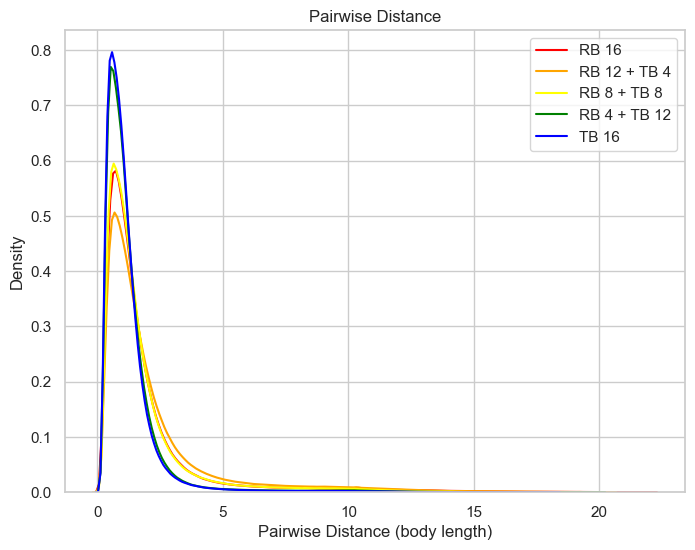

In [39]:
#Pairwise distance plot

sns.set(style='whitegrid')
sns.set_palette('muted')

fig = plt.figure(figsize=(8, 6))

colors = ['red', 'orange', 'yellow', 'green', 'blue']
labels = ['RB 16', 'RB 12 + TB 4', 'RB 8 + TB 8', 'RB 4 + TB 12', 'TB 16']
for i in range(5): # treatment
    pd = np.empty((0, 16, 16))
    for j in range(5): #replicate
        pd = np.concatenate((pd, pw_dist[i][j]))

    sns.kdeplot(pd.ravel(), fill=False, color=colors[i], label=labels[i])

plt.title("Pairwise Distance")
plt.xlabel("Pairwise Distance (body length)")
plt.ylabel("Density")
plt.legend()
fig.show()
fig.savefig('pairwise_distance_plot.png', dpi=300, bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

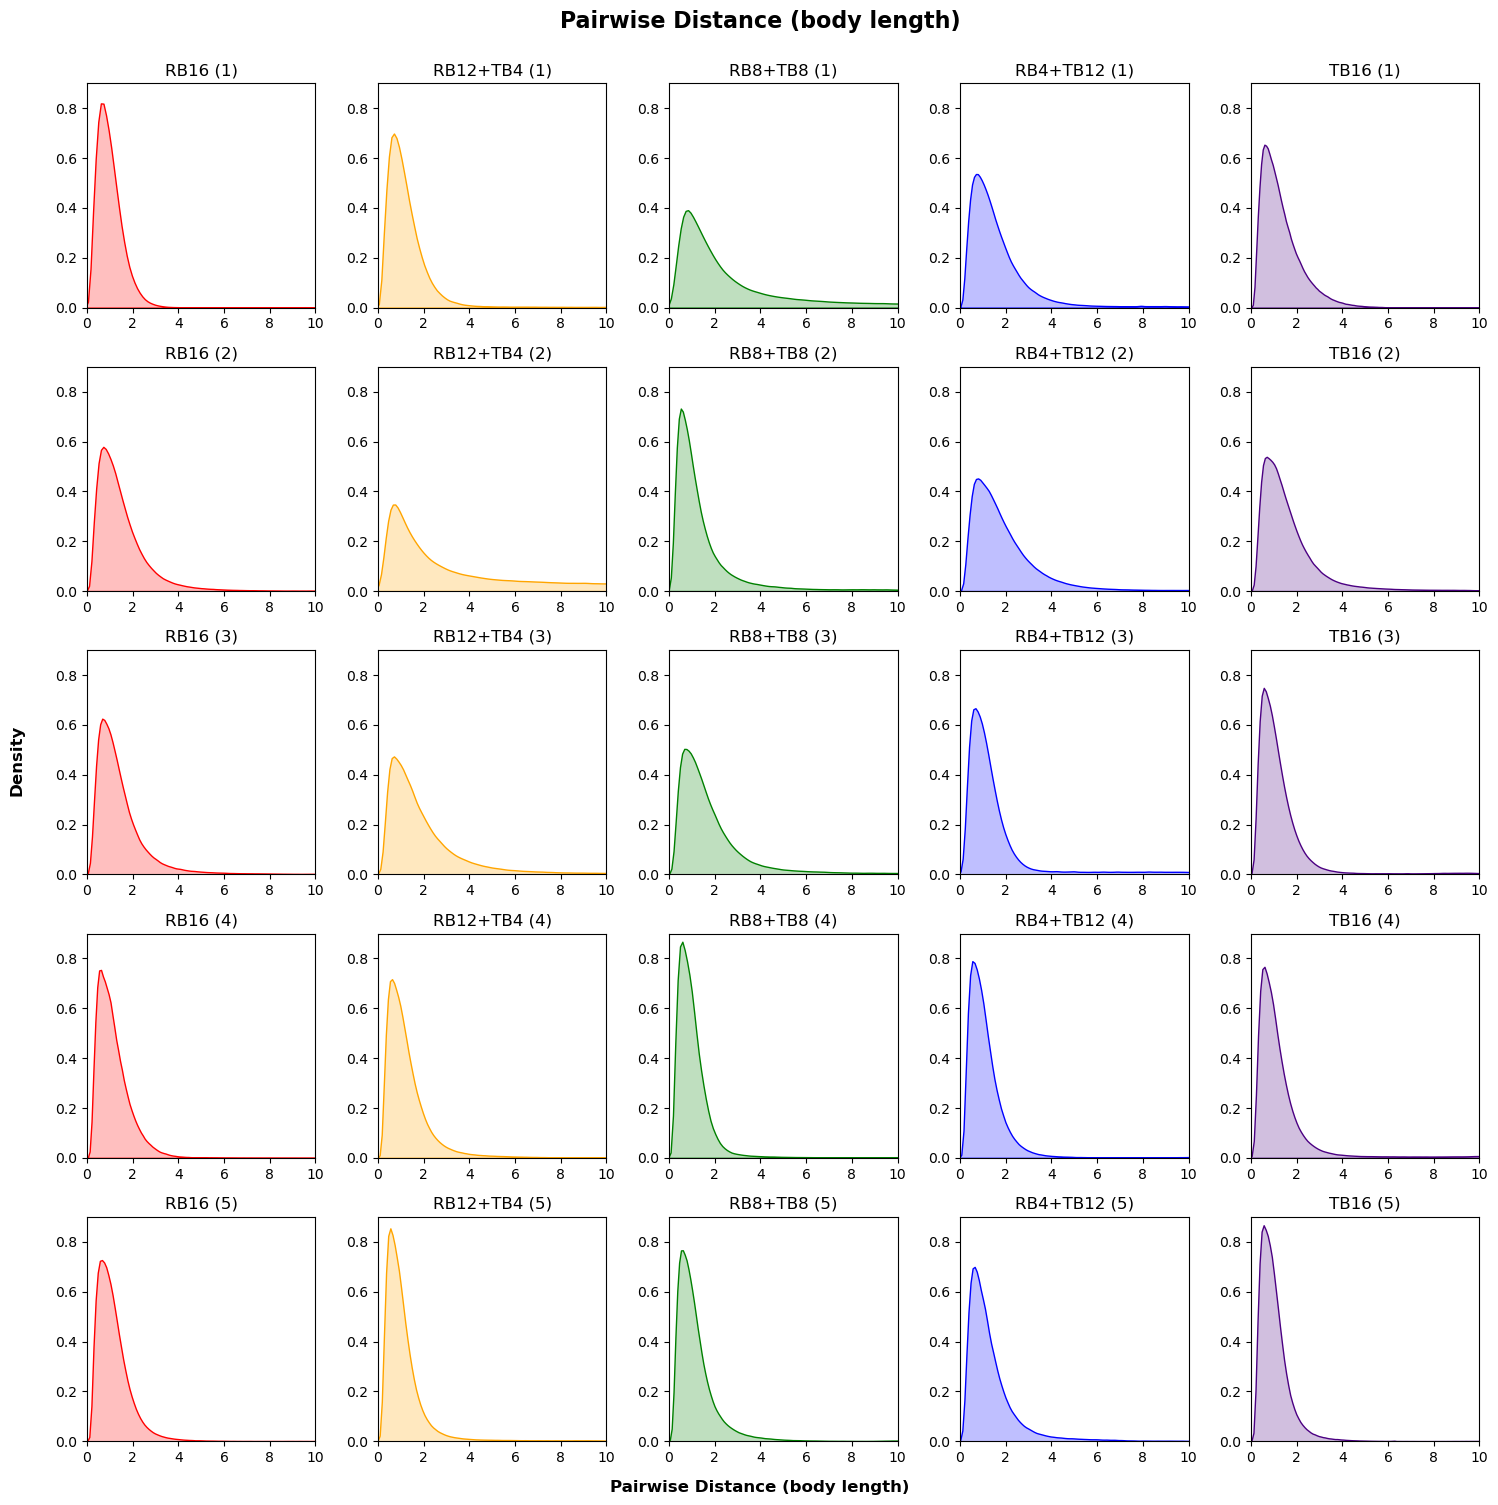

In [45]:
#Pairwise distance plots replicate-wise

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

colors = ['red', 'orange', 'green', 'blue', 'indigo']

for i in range(5):
    for j in range(5):
        index = i * 5 + j  # Calculate the index of ind_speed
        sns.kdeplot(pw_dist[i][j].ravel(),
                    ax=axes[i, j], fill=True, color=colors[index % len(colors)])
        
        axes[i, j].set_ylim(0, 0.9)
        axes[i, j].set_xlim(0, 10)
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')


fig.suptitle('Pairwise Distance (body length)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Pairwise Distance (body length)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('pairwise_distance_gs16_replicatewise_bodylength.png', bbox_inches='tight')


In [ ]:
#Pairwise distance (concatenate)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5): # treatment
    pd = np.empty((0, 16, 16))
    for j in range(5): #replicate
        pd = np.concatenate((pd, pw_dist[j][i]))
        
    sns.kdeplot(s.ravel(), ax=axes[i], fill=True, color=colors[i])
    
    axes[i].set_ylim(0, 0.9)
    axes[i].set_xlim(0, 10)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(f'{treatments[i]}')

fig.suptitle('Pairwise distance (body length)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Pairwise Distance (body length)', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('pairwise_distance_concatenate_bodylength.png', bbox_inches='tight')

In [37]:
# NEAR NEIGHBOUR DISTANCE

pw_dist = np.empty((5,5), dtype = object)
nnd = np.empty((5,5), dtype = object)

for treatment in range (5):
    for replicate in range (5):
        T, N = pos[treatment, replicate].shape[:2]
        pw_dist[treatment, replicate] = np.empty ((T, N, N))
        nnd [treatment, replicate] = np.empty ((T, N))
        for t in range (T):
            pair_dist = squareform(pdist(pos[treatment, replicate][t, :, :]))
            pair_dist[pair_dist == 0] = np.nan
            pw_dist[treatment, replicate][t,:,:] = pair_dist
            nnd[treatment, replicate][t, :] = np.nanmin(pair_dist)

/var/folders/yx/fr740nw51gx5ylj1n1z8jp7c0000gn/T/ipykernel_4927/1616475074.py:15: RuntimeWarning: All-NaN slice encountered
  nnd[treatment, replicate][t, :] = np.nanmin(pair_dist)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

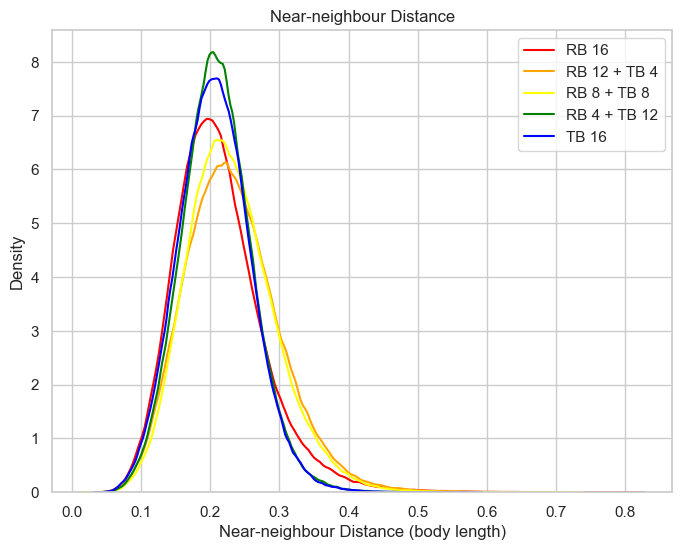

In [38]:
#NND plot

sns.set(style='whitegrid')
sns.set_palette('muted')

fig = plt.figure(figsize=(8, 6))

colors = ['red', 'orange', 'yellow', 'green', 'blue']
labels = ['RB 16', 'RB 12 + TB 4', 'RB 8 + TB 8', 'RB 4 + TB 12', 'TB 16']
for i in range(5): # treatment
    nd = np.empty((0, 16))
    for j in range(5): #replicate
        nd = np.concatenate((nd, nnd[i][j]))

    sns.kdeplot(nd.ravel(), fill=False, color=colors[i], label=labels[i])

plt.title("Near-neighbour Distance")
plt.xlabel("Near-neighbour Distance (body length)")
plt.ylabel("Density")
plt.legend()
fig.show()
fig.savefig('near_neighbour_distance_plot.png', dpi=300, bbox_inches='tight')

In [14]:
#POLARIZATION

In [18]:
replicates = ['6', '7', '8', '9', '10']
treatments = [
    'RB16',
    'RB12+TB4',
    'RB8+TB8',
    'RB4+TB12',
    'TB16'
]

pol = np.empty((5, 5), dtype=object)

for t, treatment in enumerate(treatments):
    for r, replicate in enumerate(replicates):
        filename = f'/Users/jahanvitiwari/Desktop/Arshad modified codes/cleaned data/MS_RB+TB_{replicate}_{treatment}_pol.csv'
        try:
            data = pd.read_csv(filename)
            pol[r][t] = data[['pol_x', 'pol_y']].values
        except:
            print(f'File: {filename} not found.')
# for r in replicates:
#     for t in treatments:
#         print(f'/Users/jahanvitiwari/Desktop/Arshad modified codes/cleaned data/MS_RB+TB_{r}_{t}_traj.npz')

In [19]:
polarization = np.empty_like(pol)
for t in range(5):
    for r in range(5):
         polarization[t][r] = np.linalg.norm(pol[t][r], axis=1)

In [20]:
replicates = ['1', '2', '3', '4', '5']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

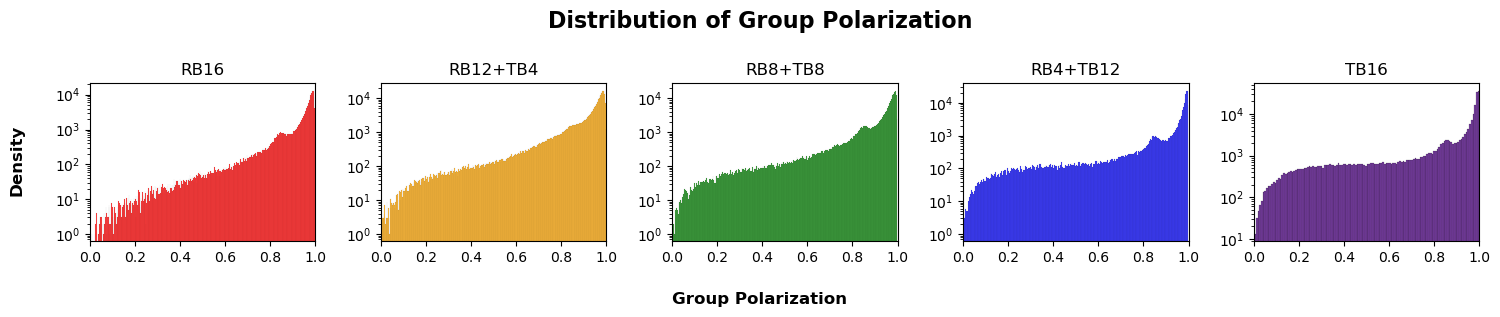

In [23]:
#GROUP POLARIZATION (CONCATENATE)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5): # treatment
    p = np.empty((1))
    for j in range(5): #replicate
        p = np.concatenate((p, polarization[j][i]))
               
    sns.histplot(p.ravel(), ax=axes[i], log=True, fill=True, color=colors[i])

   # axes[i].set_ylim(0, 20)
    axes[i].set_xlim(0, 1)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(f'{treatments[i]}')


fig.suptitle('Distribution of Group Polarization', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Group Polarization', fontsize=12, fontweight='bold')
fig.supylabel('Density', x=0, fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('distribution_of_group_polarization_concatenate.png', bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

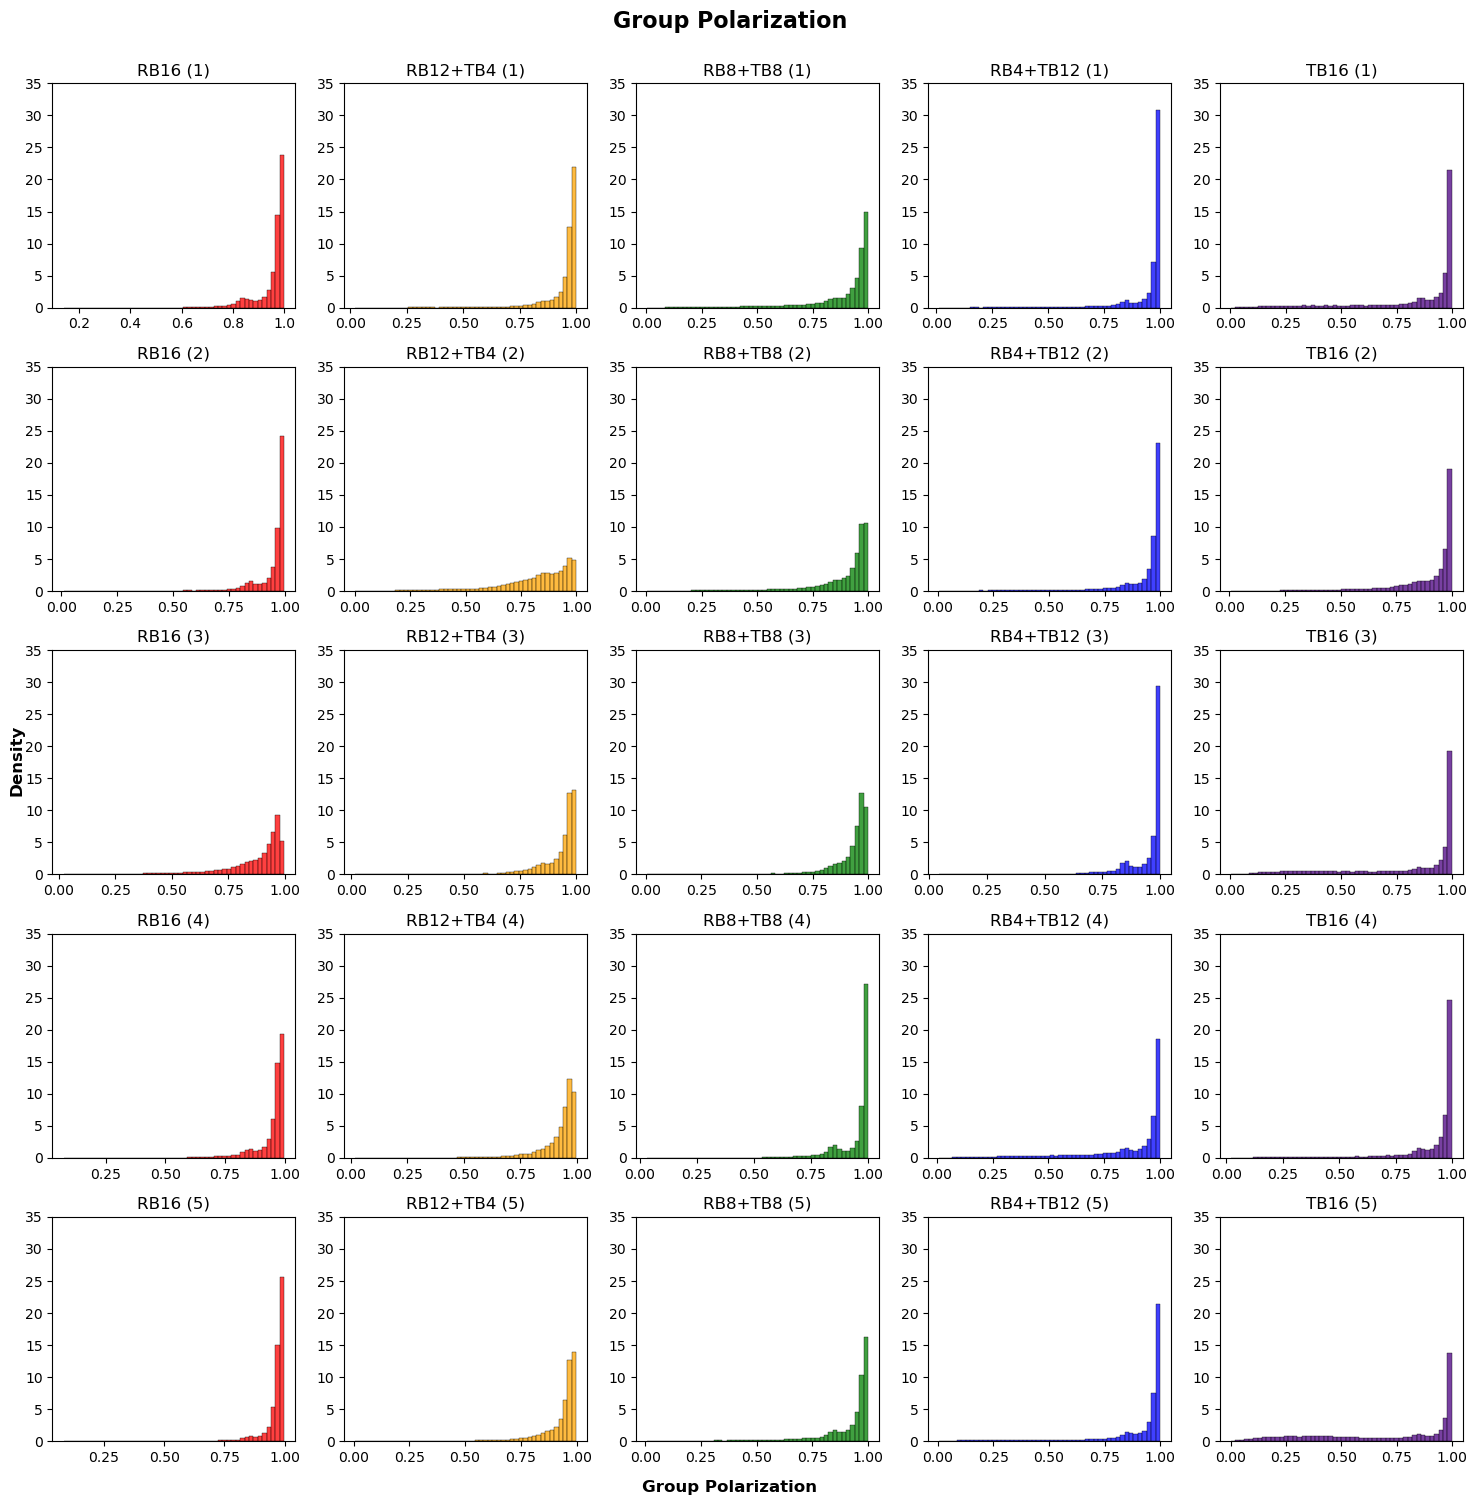

In [15]:
#GROUP POLARIZATION (REPLICATE WISE)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

colors = ['red', 'orange', 'green', 'blue', 'indigo']

for i in range(5):
    for j in range(5):
        index = i * 5 + j  # Calculate the index of ind_speed
        sns.histplot(polarization[i][j],
                     ax=axes[i, j], 
                     bins=50,
                     color=colors[index % len(colors)], 
                     kde=False, 
                     stat='density') 
       
        axes[i, j].set_ylim(0, 35)
        #axes[i, j].set_xlim(0, 1)
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')


fig.suptitle('Group Polarization', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Group Polarization', fontsize=12, fontweight='bold')
fig.supylabel('Density', fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('polarization_barbs_histplot_replicatewise.png', bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

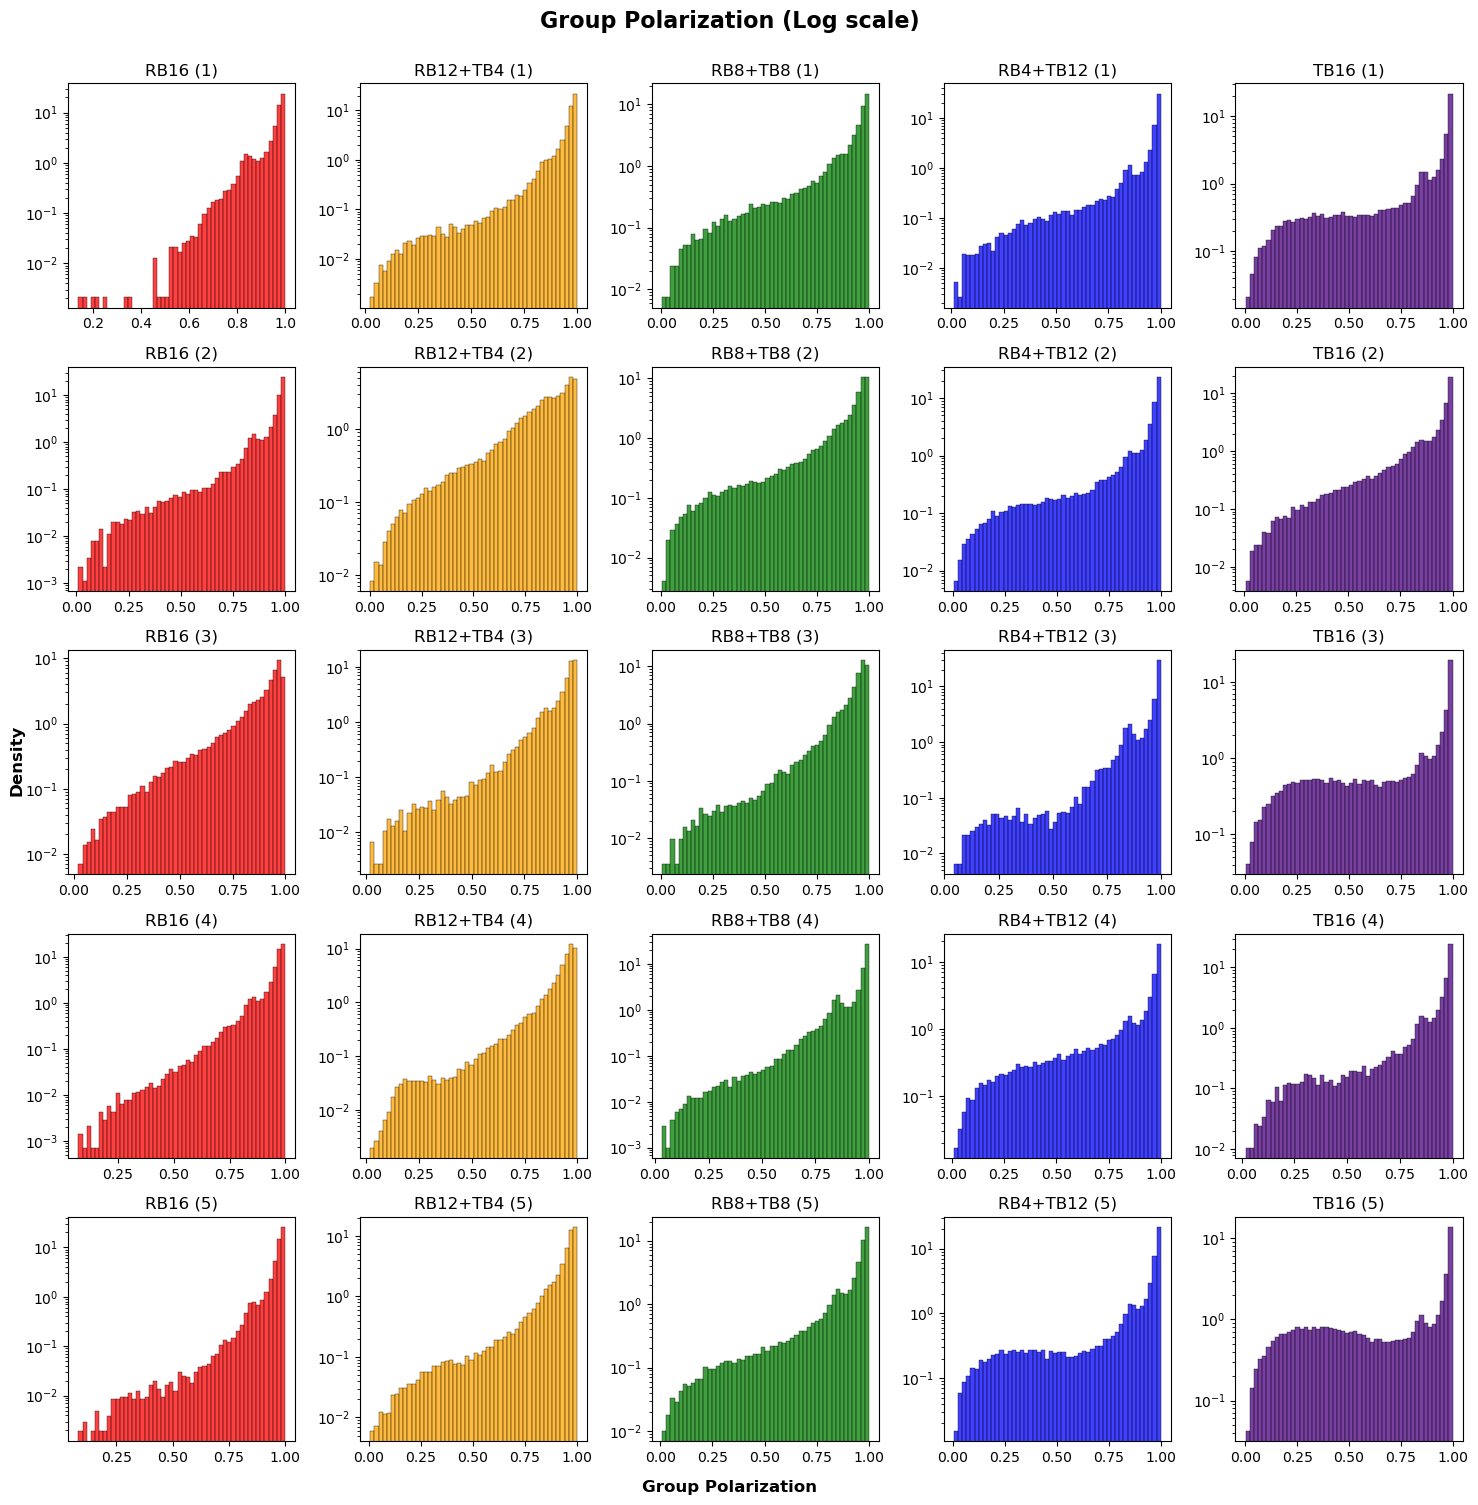

In [17]:
# GROUP POLARIZATION (LOG SCALE-REPLICATE WISE)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

colors = ['red', 'orange', 'green', 'blue', 'indigo']
for i in range(5):
    for j in range(5):
        index = i * 5 + j 
        sns.histplot(polarization[i][j],
                     ax=axes[i, j], 
                     bins=50, 
                     color=colors[index % len(colors)],  
                     kde=False, log = True, 
                     stat='density') 
        
        #axes[i, j].set_ylim(0, 50)
        #axes[i, j].set_xlim(0, 1)
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f'{treatments[j]} ({replicates[i]})')

fig.suptitle('Group Polarization (Log scale)', y=1, fontsize=16, fontweight='bold')
fig.supxlabel('Group Polarization', fontsize=12, fontweight='bold')
fig.supylabel('Density', fontsize=12, fontweight='bold')

fig.tight_layout()
fig.show()
fig.savefig('polarization(logscale)_barbs_histplot_replicatewise.png', bbox_inches='tight')